## **Inria Aerial Satellite Image Labelling**
The main aim of this challenge is to be able to classify pixels as 'building' or 'not building'. This is a clear case of semantic segmentation. We have180 aerial images from various cities with a resolution of 5000 X 5000, along with the segmented masks of 5000 X 5000. Our goal is to classify each of the pixels in the test image and generate a masks for the test images too.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import fastai
from fastai.vision import *
import torch
import torchvision.transforms.functional as F

import tarfile, os,pathlib

Mounting Google drive to Colab for file access !

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Download preprocessed data from drive to colab
Download the pre processed tar files of generated patches stored on drive to colab and extract for use.

In [0]:
!mkdir '/content/InriaPatches'
!cp '/content/drive/My Drive/masks.tar' '/content/InriaPatches/'
!cp '/content/drive/My Drive/train.tar' '/content/InriaPatches/'
!cp '/content/drive/My Drive/valid.tar' '/content/InriaPatches/'

In [0]:
!tar -zxf /content/InriaPatches/train.tar -C /content/InriaPatches/

In [0]:
!tar -zxf /content/InriaPatches/masks.tar -C /content/InriaPatches/

In [0]:
!tar -zxf /content/InriaPatches/valid.tar -C /content/InriaPatches/

In [0]:
#Remove tar files from colab
!rm -rf /content/InriaPatches/*.tar

## EDA

Import required fastai libraries

In [0]:
from fastai.vision import *
from fastai import *
import fastai
from fastai.callbacks.hooks import *
print(fastai.__version__)

1.0.52


Check the sample images  and their dimensions in train and test folders

In [0]:
root_dir = Path('/content/InriaPatches')
train_path = root_dir/'train'
valid_path = root_dir/'valid'
mask_path = root_dir/'masks'

In [0]:
images = get_image_files(train_path)
masks = get_image_files(mask_path)
valids = get_image_files(valid_path)

In [0]:
len(images), len(masks), len(valids)

(62000, 72000, 10000)

In [0]:
# Size of each image and its mask
image = open_image(images[0])
img_size = np.array(image.shape[1:])
print(image.shape)

mask = open_image(masks[0], div=True)
print(mask.shape)
mask_size = np.array(mask.shape[1:])

np.unique(np.array(mask.data))

torch.Size([3, 250, 250])
torch.Size([3, 250, 250])


array([0., 1.], dtype=float32)

Function to get the corresponding mask file (labels) of an image file (inputs)

In [0]:
get_mask_file = lambda x: mask_path/f'{x.stem.split("/")[-1]}.tif'
img = images[0]
vimg = valids[1]
vimg, get_mask_file(vimg)


(PosixPath('/content/AerialImagePatches/valid/tyrol-w4_271.tif'),
 PosixPath('/content/AerialImagePatches/masks/tyrol-w4_271.tif'))

## Data Visualization 

In [0]:
import matplotlib.pyplot as plt

'''Display a sample of random images as their corresponding masks'''
def display_image_mask_grid(n):
  images_list = []
  for i in range(n):
    images_list.append(random.choice(os.listdir(train_path)))
  for idx, image in enumerate(images_list):  
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    img = plt.imread(str(train_path/image))
    axs[0].imshow(img)
    msk = plt.imread(str(mask_path/image))
    axs[1].imshow(msk, cmap='gray')    
    plt.grid(False)
    plt.show()  
    

display_image_mask_grid(5)

## U-Net Model

In [0]:
import numpy as np
codes = np.array(['NotBuilding','Building'])
# src_size = np.array(mask.shape[1:])
size = 250
bs = 16
size, bs 

(250, 16)

In [0]:
class MaskSegmentationLabelList(SegmentationLabelList):
    def open(self, fn): 
      return open_mask(fn, div=True)

class MaskSegmentationItemList(ImageList):
    _label_cls,_square_show_res = MaskSegmentationLabelList, False
    

In [0]:
src = MaskSegmentationItemList.from_folder(root_dir).split_by_folder(train='train', valid='valid').label_from_func(get_mask_file, classes=codes)
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)

In [0]:
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats)
)


In [0]:
# data.show_batch(rows=3, figsize=(12,9))

In [0]:
# Display data(x,y) in train and validation sets
len(data.train_ds.x.items), len(data.train_ds.y.items),len(data.valid_ds.x.items), len(data.valid_ds.y.items)

(62000, 62000, 10000, 10000)

In [0]:
data.classes

array(['NotBuilding', 'Building'], dtype='<U11')

In [0]:
def jaccard_loss(input, target):
  smooth = 1.
  input = input[:,1,None].sigmoid()
  iflat = input.contiguous().view(-1).float()
  tflat = target.view(-1).float()
  intersection = (iflat * tflat).sum()
  cardinality = (iflat + tflat).sum()
  union = cardinality - intersection
  return (1 - ((intersection + smooth) / (union + smooth)))

def combo_loss(pred, targ):
  bce_loss = CrossEntropyFlat(axis=1)
  return bce_loss(pred,targ) + jaccard_loss(pred,targ)

In [0]:
iou = partial(dice, iou=True)
metrics = [accuracy_thresh, iou, combo_loss]

In [0]:
from fastai.callbacks import * 
learn = unet_learner(data, models.resnet18, metrics=[accuracy_thresh, iou, combo_loss], loss_func = combo_loss, callback_fns=[partial(CSVLogger, append=True)])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:02<00:00, 22205392.94it/s]


In [0]:
learn.loss_func = combo_loss

##Training the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


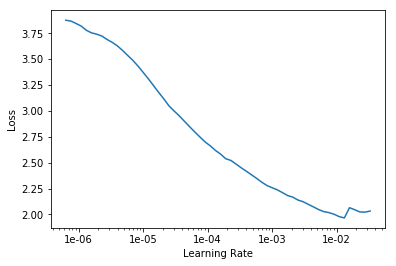

In [0]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-03

epoch,train_loss,valid_loss,accuracy_thresh,dice,combo_loss,time
0,0.529440,0.569555,0.931831,0.627073,0.569556,47:13
1,0.455908,0.432022,0.949649,0.691568,0.432022,46:18
2,0.421066,0.422356,0.951489,0.697324,0.422356,46:11
3,0.374783,0.392002,0.956442,0.722045,0.392002,46:16


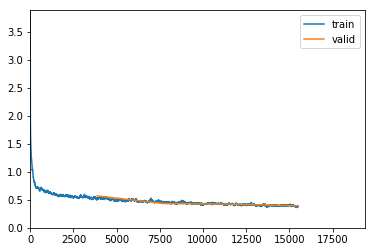

Better model found at epoch 0 with dice value: 0.6270728707313538.
Better model found at epoch 1 with dice value: 0.6915675401687622.
Better model found at epoch 2 with dice value: 0.6973236799240112.
Better model found at epoch 3 with dice value: 0.7220448851585388.
Buffered data was truncated after reaching the output size limit.

In [0]:
learn.fit_one_cycle(5, slice(lr),callbacks=[ShowGraph(learn),SaveModelCallback(learn, every='improvement', monitor='dice', name='inria_250_resnet18_stg1')])

In [0]:
learn.csv_logger.read_logged_file()

,epoch,train_loss,valid_loss,accuracy_thresh,dice,combo_loss,time
0,0,2437.308105,#na#,00:56,NaN,NaN,NaN
1,epoch,train_loss,valid_loss,accuracy_thresh,dice,combo_loss,time
2,0,0.529440,0.569555,0.931831,0.627073,0.569556,47:13
3,1,0.455908,0.432022,0.949649,0.691568,0.432022,46:18
4,2,0.421066,0.422356,0.951489,0.697324,0.422356,46:11
5,3,0.374783,0.392002,0.956442,0.722045,0.392002,46:16
6,4,0.371787,0.379434,0.957749,0.727187,0.379434,46:21


In [0]:
#Copy model to drive
learn.save('inria_250_resnet18_stg1')

In [0]:
!cp '/content/InriaPatches/models/inria_250_resnet18_stg1.pth' '/content/drive/My Drive/fellowship/'
!cp '/content/InriaPatches/models/tmp.pth' '/content/drive/My Drive/fellowship/'


## Finetuning the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06


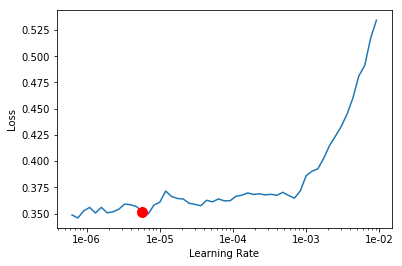

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy_thresh,dice,combo_loss,time
0,0.372821,0.381526,0.957427,0.726395,0.381526,47:28
1,0.377207,0.380749,0.957617,0.725986,0.380749,47:29
2,0.389176,0.379880,0.957703,0.727469,0.379880,47:30
3,0.372086,0.379295,0.957769,0.727601,0.379295,47:32
4,0.372602,0.379350,0.957821,0.727879,0.379350,47:31


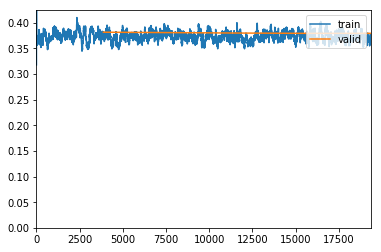

Better model found at epoch 0 with dice value: 0.7263954877853394.
Better model found at epoch 2 with dice value: 0.7274691462516785.
Better model found at epoch 3 with dice value: 0.7276008725166321.
Better model found at epoch 4 with dice value: 0.7278786897659302.


In [0]:
lr = 6e-06
learn.fit_one_cycle(5, slice(lr),callbacks=[ShowGraph(learn),SaveModelCallback(learn, every='improvement', monitor='dice', name='inria_250_resnet18_stg2')])

In [0]:
learn.csv_logger.read_logged_file()

,epoch,train_loss,valid_loss,accuracy_thresh,dice,combo_loss,time
0,0,2437.308105,#na#,00:56,NaN,NaN,NaN
1,epoch,train_loss,valid_loss,accuracy_thresh,dice,combo_loss,time
2,0,0.529440,0.569555,0.931831,0.627073,0.569556,47:13
3,1,0.455908,0.432022,0.949649,0.691568,0.432022,46:18
4,2,0.421066,0.422356,0.951489,0.697324,0.422356,46:11
5,3,0.374783,0.392002,0.956442,0.722045,0.392002,46:16
6,4,0.371787,0.379434,0.957749,0.727187,0.379434,46:21
7,epoch,train_loss,valid_loss,accuracy_thresh,dice,combo_loss,time
8,0,2.319549,#na#,00:47,NaN,NaN,NaN
9,epoch,train_loss,valid_loss,accuracy_thresh,dice,combo_loss,time


In [0]:
#Copy model to drive
learn.save('inria_250_resnet18_stg2')

In [0]:
!cp '/content/InriaPatches/models/inria_250_resnet18_stg2.pth' '/content/drive/My Drive/fellowship/'
!cp '/content/InriaPatches/models/tmp.pth' '/content/drive/My Drive/fellowship/'

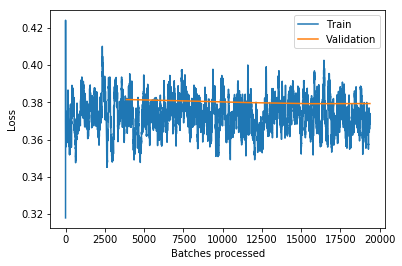

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.export()

In [0]:
!ls '/content/InriaPatches/models'

inria_250_resnet18_stg1.pth  inria_250_resnet18_stg2.pth  tmp.pth


In [0]:
!cp '/content/InriaPatches/export.pkl' '/content/drive/My Drive/fellowship/export.pkl'

## Inference

In [0]:
!mkdir '/content/InriaPatches'
!cp '/content/drive/My Drive/test.tar' '/content/InriaPatches/'

In [0]:
!tar -zxf /content/InriaPatches/test.tar -C /content/InriaPatches/

In [0]:
!cp '/content/drive/My Drive/fellowship/inria_250_resnet18_stg1.pth' '/content/InriaPatches/'
!cp '/content/drive/My Drive/fellowship/inria_250_resnet18_stg2.pth' '/content/InriaPatches/'
!cp '/content/drive/My Drive/fellowship/export.pkl' '/content/InriaPatches/'
!cp '/content/drive/My Drive/fellowship/tmp.pth' '/content/InriaPatches/'

In [0]:
class MaskSegmentationLabelList(SegmentationLabelList):
    def open(self, fn): 
      return open_mask(fn, div=True)

class MaskSegmentationItemList(ImageList):
    _label_cls,_square_show_res = MaskSegmentationLabelList, False
    

In [0]:
get_mask_file = lambda x: mask_path/f'{x.stem.split("/")[-1]}.tif'

In [0]:
size=250
bs=16
codes = np.array(['NotBuilding','Building'])
tfms = get_transforms(flip_vert=True, max_lighting=0.3, max_zoom=1.2, max_warp=0.) 
src = MaskSegmentationItemList.from_folder(root_dir).split_by_folder(train='train',valid='valid').label_from_func(get_mask_file, classes=codes).add_test_folder(test_folder='test')
data_test = (src.transform(tfms, size=size).databunch(bs=bs).normalize(imagenet_stats))
data_test


ImageDataBunch;

Train: LabelList (62000 items)
x: MaskSegmentationItemList
Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
y: MaskSegmentationLabelList
ImageSegment (1, 250, 250),ImageSegment (1, 250, 250),ImageSegment (1, 250, 250),ImageSegment (1, 250, 250),ImageSegment (1, 250, 250)
Path: /content/InriaPatches;

Valid: LabelList (10000 items)
x: MaskSegmentationItemList
Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
y: MaskSegmentationLabelList
ImageSegment (1, 250, 250),ImageSegment (1, 250, 250),ImageSegment (1, 250, 250),ImageSegment (1, 250, 250),ImageSegment (1, 250, 250)
Path: /content/InriaPatches;

Test: LabelList (72000 items)
x: MaskSegmentationItemList
Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
y: EmptyLabelList
,,,,
Path: /content/InriaPatches

In [0]:
def jaccard_loss(input, target):
  smooth = 1.
  input = input[:,1,None].sigmoid()
  iflat = input.contiguous().view(-1).float()
  tflat = target.view(-1).float()
  intersection = (iflat * tflat).sum()
  cardinality = (iflat + tflat).sum()
  union = cardinality - intersection
  return (1 - ((intersection + smooth) / (union + smooth)))

def combo_loss(pred, targ):
  bce_loss = CrossEntropyFlat(axis=1)
  return bce_loss(pred,targ) + jaccard_loss(pred,targ)

In [0]:
iou = partial(dice, iou=True)
metrics = [accuracy_thresh, iou, combo_loss]

In [0]:
learn = unet_learner(data_test, models.resnet18, metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 92430306.01it/s]


In [0]:
learn = load_learner('/content/InriaPatches/')

In [0]:
test_path = '/content/AerialImageDataset/test/images'
!mkdir '/content/InriaPatches/preds'
preds_path = Path('/content/InriaPatches/preds')
tests_patch_path = Path('/content/InriaPatches/test')

mkdir: cannot create directory ‘/content/InriaPatches/preds’: File exists


In [0]:
import torch
import torchvision

get_mask_pred = lambda x:preds_path/f'{x.name}.tif'

testfiles=[]
for test in os.listdir(test_path):
  testfiles.append(tests_patch_path/test.split('.')[0])
  
for test in testfiles:
  predictions=[]
  for i in range(1,401):
    imgfile = str(test)+'_'+str(i)+'.tif'
    img = open_image(imgfile)
    prediction = learn.predict(img)
    predictions.append(prediction[1])
  torchvision.utils.save_image(predictions,get_mask_pred(test), nrow=20, padding=0)

In [0]:
pred_source_dir = '/content/InriaPatches/preds'
def make_tarfile(output_filename, source_dir):
  with tarfile.open(output_filename, "w:gz") as tar:
    tar.add(source_dir, arcname=os.path.basename(source_dir))
    
make_tarfile('pred.tar', pred_source_dir)

In [0]:
import tarfile,re,os,pathlib,shutil

import fastai
from fastai.vision import *
import torch
import torchvision.transforms.functional as F

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Create GoogleDrive instance with authenticated GoogleAuth instance.
drive = GoogleDrive(gauth)

def upload_to_drive(file, title):
  uploaded = drive.CreateFile({'title': title})
  uploaded.SetContentFile(file)
  uploaded.Upload()
  print('Uploaded file %s with ID %s'%(file, uploaded.get('id')))


In [0]:
upload_to_drive("pred.tar","pred.tar")

Uploaded file pred.tar with ID 14OtOZxoM1epfSge5aWbPK0Aw1rtGkRk8
